# Sistem Rekomendasi Film Indonesia Menggunakan Teknik Content-Based Filtering

Oleh: Handhika Yanuar Pratama

Pada proyek ini akan dibuat sistem rekomendasi film Indonesia untuk pengguna menggunakan *content-based filtering*. Dataset dari film ini diperoleh dari situs kaggle dengan judul [IMDB Synopsis Indonesian Movies](https://www.kaggle.com/antoniuscs/imdb-synopsis-indonesian-movies).


## Data Gathering

In [ ]:
!pip install kaggle # Melakukan instalasi module untuk menghubungkan colab dengan kaggle
!mkdir ~/.kaggle # Membuat direktori untuk menyimpan konfigurasi API kaggle
!cp kaggle.json ~/.kaggle/ # Memindahkan file API ke direktori yang dibuat sebelumnya
!chmod 600 ~/.kaggle/kaggle.json # Mengubah privillege pada file API kaggle untuk memberikan akses read and write pada sistem (600)

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d antoniuscs/imdb-synopsis-indonesian-movies # Mengunduh dataset dari kaggle ke colab

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 44.4MB/s]


In [ ]:
!unzip imdb-synopsis-indonesian-movies.zip # Melakukan ekstraksi file hasil unduhan kaggle

Archive:  imdb-synopsis-indonesian-movies.zip
  inflating: imdb_indonesian_movies_2.csv  


## Import Modules and Dataset

In [ ]:
# Module untuk pengolahan data
from sklearn.feature_extraction.text import TfidfVectorizer # Melakukan ekstraksi fitur pada text menggunakan TfidfVectorizer
from nltk.corpus import stopwords # Menerapkan stopwords pada data teks
import nltk # Membantu pekerjaan yang berkaitan dengan pengolahan teks
nltk.download('stopwords') # Melakukan pengunduhan stopwords untuk nantinya diterapkan pada text
import pandas as pd # Melakukan pengolahan data dalam bentuk dataframes
import numpy as np # Melakukan pengolahan data numerik

# Module untuk visualisasi data
import matplotlib.pyplot as plt # Melakukan visualisasi data

# Module untuk pembuatan sistem rekomendasi
from sklearn.metrics.pairwise import sigmoid_kernel # Membuat model menggunakan teknik sigmoid kernel

# Module untuk evaluasi model sistem rekomendasi
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score # Matriks umum untuk melakukan evaluasi pada model sistem rekomendasi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Membaca dataset yang telah diunduh menggunakan pandas
df = pd.read_csv("imdb_indonesian_movies_2.csv")

## Data Understanding

In [ ]:
# Melihat lima baris pertama dari dataset
df.head()

,judul_film,ringkasan_sinopsis,genre
0,Sunan Kalijaga,Raden Mas Said putra sulung Tumenggung Wilarik...,Drama
1,Gie,Soe Hok Gie adalah seorang aktivis yang hidup ...,Drama
2,Guru Bangsa Tjokroaminoto,Guru Bangsa Tjokroaminoto menceritakan tentang...,Drama
3,POL Movie,POL menceritakan kisah hidup yang luar biasa d...,Drama
4,Sang pencerah,Perjalanan pahlawan Indonesia KH Ahmad Dahlan ...,Drama


In [ ]:
# Melihat genre film yang tersedia dari dataset tersebut
df.genre.value_counts()

Laga        202
Drama       202
Komedi      201
Romantis    200
Horor       200
Name: genre, dtype: int64

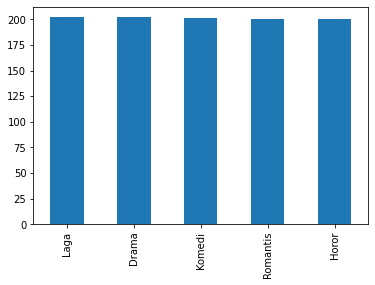

In [ ]:
# Melakukan visualisasi dari genre film
df.genre.value_counts().plot(kind='bar')

In [ ]:
# Melihat ukuran dataset
df.shape

(1005, 3)

In [ ]:
# Menampilkan informasi umum dari dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   judul_film          1005 non-null   object
 1   ringkasan_sinopsis  1005 non-null   object
 2   genre               1005 non-null   object
dtypes: object(3)
memory usage: 23.7+ KB


Dari proses pemahaman dataset di atas diperoleh informasi sebagai berikut:
1. Data terdiri dari tiga buah kolom antara lain judul_film, ringkasan_sinopsis, dan genre
2. Data terdiri dari 1005 baris dan tidak ada nilai *null* pada data tersebut
3. Terdapat lima genre film yang tersedia pada dataset yang mana genre tersebut terdiri dari Drama, Laga, Komedi, Romantis, dan Horor

In [ ]:
# Memeriksa salah satu isi dari kolom ringkasan_sinopsis
df.ringkasan_sinopsis[0]

'Raden Mas Said putra sulung Tumenggung Wilarikta di bawah Kerajaan Majapahit yang berkuasa di wilayah Tuban melihat sekeluarga miskin yang menderita busung lapar. Ia merasa sangat prihatin dan hati nuraninya tergugah untuk menolong. Kemudian ia mencoba secara diam-diam mengambil makanan dari lumbung orang tuanya. Perbuatan itu tidak disetujui orang tuanya bahkan ia dihukum sekap di gudang makanan itu. Sejak kejadian itu RM Said yang tumbuh dewasa tidak betah tinggal di rumah. Ia berkelana dari daerah satu ke daerah lainnya. Dari sanalah ia tahu betapa banyak penyelewengan dan kesewenang-wenangan para lurah yang munafik. Mereka selalu mengkambing-hitamkan Tumenggung untuk menutupi kejahatannya. Atas laporan RM Said ayahnya kemudian sadar. Tetapi kemudian ia dianggap sebagai sumber fitnah. Dalam kelananya kemudian ia bertemu dengan Sunan Bonang yang banyak mencurahkan ilmunya kepada RM Said. Ia pun kemudian melakukan tapa di pinggir kali. Berkat ketabahannya menghadapi berbagai cobaan R

## Data Preparation

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
# Membuat fungsi TfidfVectorizer dan menyimpannya ke dalam variabel bernama tfidf
tfidf = TfidfVectorizer(strip_accents='unicode', # Menghilangkan aksen dan menerapkan normalisasi karakter unicode
                        analyzer='word', # Membuat fitur yang terbuat dari kata atau karakter n-gram
                        token_pattern=r'\w{1,}', # Menerapkan regular expression dalam pembuatan token
                        ngram_range=(1,3), # Batas atas dan bawah kisaran nilai n-gram berbeda untuk diekstraksi
                        stop_words=stopwords.words('indonesian')) # Menerapkan stopwrods Indonesia

In [ ]:
# Melakukan transformasi feature dari teks menjadi vektor dengan tfidf pada ringkasan sinopsis
tfidf_matrix = tfidf.fit_transform(df['ringkasan_sinopsis'])

In [ ]:
# Memeriksa output hasil vektorisasi teks menggunakan tfidfvectorizer
tfidf_matrix

<1005x13515 sparse matrix of type '<class 'numpy.float64'>'
	with 77522 stored elements in Compressed Sparse Row format>

In [ ]:
# Melihat ukuran data dari tfidf_matrix
tfidf_matrix.shape

(1005, 13515)

## Data Modelling

### Menggunakan Cosine Similarity

In [ ]:
# Menghitung cosine similarity dari dataframe
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
# Menyimpan hasil perhitungan pada dataframe
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['judul_film'], columns=df['judul_film'])
cosine_sim_df.head(3)

judul_film,Sunan Kalijaga,Gie,Guru Bangsa Tjokroaminoto,POL Movie,Sang pencerah,Sundul Gan: The Story of Kaskus,Maju Terus!,Pendidik Berjiwa Merdeka,Jokowi,Jaka Sembung & Bergola Ijo,Brownies,Adèle,An Extraordinary Mother,Iblis Jalanan: Street Demon,Precious Herbs,Anak sabiran di balik cahaya gemerlapan: Sang arsip,Anak-Anak Srikandi,Banda the Dark Forgotten Trail,Denok & Gareng,Tarling is Darling,Terraform,The Year of Living Vicariously,Menarung Jiwani,Prison and Paradise,Rock in Solo: Heritage Metalfest,"Kitos, Selamat Tinggal Kota Merah",3600 Detik,A Man Called Ahok,Tanah air beta,Tendangan dari langit,3 Nafas Likas,Aib #Cyberbully,Air Mata Terakhir Bunda,Akibat pergaulan bebas,Alas Pati: Hutan Mati,Aruna & Lidahnya,Babi buta yang ingin terbang,Badai jalanan,Barbi3,Batas,...,Dear Nathan Hello Salma,Di dadaku ada cinta,From Bandung with Love,Gita cinta dari SMA,Hanum & Rangga: Faith & The City,I Love You from 38000 Feet,I Love You Om…,It's Not Here Anymore,Jakarta Love Story,Karena dia,Kisah Dua Jendela,Kukejar Cinta ke Negeri Cina,Lost in Love,Love Story,Love Story (I),Me vs. High Heels,Merangkul langit,Misteri cinta,Pupus,Purple Love,R - Raja Ratu & Rahasia,Remember When,Roda-roda asmara di bukit sentul,Roman picisan,Rompis,Ruang,Rudy Habibie,Sang Penari,Selingkuh,Siluman Teluk Gonggo,Tentang cinta,The Perfect Husband,The Right One (I),The Sinking of Van Der Wijck,The Sun The Moon & The Hurricane,Winter in Tokyo,Petualang Cinta,Last Night (III),Path of Light,Kulihat cinta di matanya
judul_film,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Sunan Kalijaga,1.000000,0.019970,0.036425,0.030350,0.046544,0.037039,0.049529,0.024061,0.070029,0.009043,0.074009,0.038726,0.059595,0.050627,0.050251,0.039224,0.019959,0.043218,0.036280,0.033071,0.033554,0.023311,0.035301,0.016730,0.016322,0.026170,0.032007,0.034627,0.043299,0.057203,0.029918,0.016847,0.039196,0.018730,0.057349,0.048252,0.032676,0.043145,0.060395,0.034217,...,0.025566,0.037260,0.045214,0.000000,0.015316,0.020217,0.008572,0.013628,0.027789,0.024409,0.000000,0.022031,0.000000,0.018321,0.034686,0.062200,0.026422,0.024634,0.067098,0.043440,0.014863,0.031512,0.012512,0.023301,0.044277,0.042746,0.030626,0.059632,0.023787,0.044197,0.023412,0.009201,0.045175,0.019373,0.057292,0.040814,0.069713,0.036261,0.029233,0.056843
Gie,0.019970,1.000000,0.067521,0.051001,0.014549,0.040041,0.032640,0.031060,0.046824,0.006460,0.024843,0.040218,0.030282,0.033038,0.055008,0.072383,0.029894,0.027348,0.011726,0.026661,0.045512,0.124616,0.039658,0.008304,0.017260,0.076994,0.012331,0.009363,0.028589,0.036122,0.033622,0.005200,0.016328,0.003809,0.014987,0.005755,0.016118,0.001241,0.021529,0.015643,...,0.007772,0.006359,0.019017,0.000000,0.005956,0.008885,0.015613,0.000000,0.009464,0.013457,0.000000,0.007765,0.000000,0.004318,0.014442,0.005477,0.011145,0.021684,0.024950,0.008168,0.000000,0.017489,0.012656,0.019528,0.012830,0.039048,0.024364,0.030163,0.009050,0.008061,0.018429,0.044557,0.023374,0.040523,0.027736,0.019800,0.022180,0.018562,0.022610,0.015761
Guru Bangsa Tjokroaminoto,0.036425,0.067521,1.000000,0.067044,0.008571,0.021399,0.107307,0.095370,0.044024,0.023476,0.037460,0.015683,0.058485,0.040969,0.041423,0.016176,0.027830,0.102826,0.019261,0.020122,0.039419,0.049367,0.019446,0.025892,0.024320,0.034297,0.030179,0.026251,0.039045,0.036001,0.016340,0.009592,0.044253,0.033027,0.045734,0.002800,0.027348,0.007852,0.019103,0.054820,...,0.023550,0.008857,0.019986,0.026695,0.039454,0.022805,0.020341,0.003912,0.010541,0.023812,0.030998,0.013589,0.037043,0.023555,0.024144,0.012235,0.033929,0.019597,0.043127,0.018309,0.030818,0.028175,0.022211,0.056753,0.103116,0.045832,0.062579,0.071179,0.015376,0.067139,0.027548,0.024241,0.043306,0.044895,0.058306,0.032222,0.040035,0.025530,0.053171,0.014925


In [ ]:
# Membuat fungsi untuk mendapatkan rekomendasi
# Dengan Cosine Similarity
def getRecommendedApps_cosine(film:str, recommended_apps:int=5):
  print(f'Apabila pengguna menyukai film {film[0]}\n5 film berikut ini juga mungkin akan disukai :')
  # Mencari nilai unik pada film yang disukai pengguna di baris dataframe cosine sim
  # Nilai unik (arr) dikembalikan dalam bentuk yang berurutan dari kecil ke besar 
  arr, ind = np.unique(cosine_sim_df.loc[film[0]], return_index=True)
  # Memasukkan nama film yang serupa dari index kedua terakhir sampai index n terakhir
  similar_app = []
  for index in ind[-(recommended_apps+1):-1]:
    similar_app.append(df.loc[index][0])
  # Memasukkan skor cosine dari film yang serupa mulai dari index kedua terakhir sampai index n terakhir
  cosine_score = []
  for score in arr[-(recommended_apps+1):-1]:
    cosine_score.append(score)
  # Mengembalikan sebuah dataframe berupa rekomendasi terhadap filmnya
  return pd.DataFrame(data = {"Nama film" : similar_app, "Cosine Similarity" : cosine_score}).sort_values(by='Cosine Similarity',ascending=False)

In [ ]:
# Melihat rekomendasi dari film pada baris ke-1000
getRecommendedApps_cosine(df.loc[1000])

Apabila pengguna menyukai film Winter in Tokyo
5 film berikut ini juga mungkin akan disukai :


,Nama film,Cosine Similarity
4,Bangkitnya suster gepeng,0.287400
3,Terjebak Nostalgia,0.142302
2,Letters for Raisa,0.112624
1,Saus kacang,0.085558
0,06.30,0.078414


In [ ]:
# Melihat rekomendasi dari film pada baris ke-800
getRecommendedApps_cosine(df.loc[800])

Apabila pengguna menyukai film Jendral Soedirman
5 film berikut ini juga mungkin akan disukai :


,Nama film,Cosine Similarity
4,Soegija,0.206128
3,Maju Terus!,0.189977
2,Guru Bangsa Tjokroaminoto,0.135371
1,Naga bonar,0.126705
0,Rompis,0.123179


### Menggunakan Sigmoid Kernel

In [ ]:
# Menghitung sigmoid kernel pada matrix vektorisasi tfidf
sig = sigmoid_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# Melihat output dari perhitungan sigmoid
sig

array([[0.76162523, 0.76159478, 0.76159529, ..., 0.76159528, 0.76159506,
        0.76159592],
       [0.76159478, 0.76162523, 0.76159625, ..., 0.76159473, 0.76159486,
        0.76159465],
       [0.76159529, 0.76159625, 0.76162523, ..., 0.76159495, 0.76159581,
        0.76159462],
       ...,
       [0.76159528, 0.76159473, 0.76159495, ..., 0.76162523, 0.76159675,
        0.76159565],
       [0.76159506, 0.76159486, 0.76159581, ..., 0.76159675, 0.76162523,
        0.76159624],
       [0.76159592, 0.76159465, 0.76159462, ..., 0.76159565, 0.76159624,
        0.76162523]])

In [ ]:
# Melihat output dari perhitungan sigmoid pada baris ke-0 (pertama)
sig[0]

array([0.76162523, 0.76159478, 0.76159529, ..., 0.76159528, 0.76159506,
       0.76159592])

In [ ]:
list(sig[indeks['Sunan Kalijaga']])

In [ ]:
# Membuat variabel baru yang beriskan indeks dari judul film
indeks = pd.Series(df.index, index=df['judul_film']).drop_duplicates()

In [ ]:
# Menampilkan output dari indeks
indeks

judul_film
Sunan Kalijaga                  0
Gie                             1
Guru Bangsa Tjokroaminoto       2
POL Movie                       3
Sang pencerah                   4
                             ... 
Winter in Tokyo              1000
Petualang Cinta              1001
Last Night (III)             1002
Path of Light                1003
Kulihat cinta di matanya     1004
Length: 1005, dtype: int64

In [ ]:
# Contoh ketika dilakukan pemanggilan judul sebuah film maka akan ditampilkan lokasi indeks dari film tersebut di dataframe
indeks['Sang pencerah']

4

In [ ]:
def rekomendasi_film(judul, sig=sig):
  # Mengambil indeks yang serupa dengan judul film yang diinputkan
  idx = indeks[judul] 

  # Melakukan penilaian pairwise similarity menggunakan sigmoid kernel 
  sig_scores = list(enumerate(sig[idx])) 

  # Mengurutkan output film yang memiliki kemiripan dengan film yang diinputkan
  sig_scores = sorted(sig_scores, key=lambda x:x[1], reverse=True) 

  # Menampilkan lima film termirip dengan film yang diinputkan
  sig_scores = sig_scores[1:6]

  # Mengambil indeks dari film yang mirip
  book_indeks = [i[0] for i in sig_scores]
  
  # Mencetak judul film berdasarkan indeks film serupa
  return pd.DataFrame(data = {"Rekomendasi Film" : df['judul_film'].iloc[book_indeks], 
                              "Sigmoid Similarity": ["{:.10f}".format(i[1]) for i in sig_scores]}).sort_values(by="Sigmoid Similarity", ascending=False)

In [ ]:
# Melakukan ujicoba untuk mencari film yang serupa dengan film kartini
rekomendasi_film('Kartini')

,Rekomendasi Film,Sigmoid Similarity
7,Pendidik Berjiwa Merdeka,0.7615999384
58,Identitas,0.7615982825
651,Darah garuda - Merah putih II,0.7615982371
691,The Raid 2,0.7615981726
6,Maju Terus!,0.7615981262


In [ ]:
indeks['Jendral Soedirman']

800

In [ ]:
# Melakukan ujicoba untuk mencari film yang serupa dengan film Jendral Soedirman
rekomendasi_film('Jendral Soedirman')

,Rekomendasi Film,Sigmoid Similarity
661,Soegija,0.7616005613
6,Maju Terus!,0.7616000594
2,Guru Bangsa Tjokroaminoto,0.7615983625
484,Naga bonar,0.7615980933
989,Rompis,0.7615979837


## Evaluasi

## Kesimpulan

Model untuk memberikan rekomendasi film Indonesia telah selesai dibuat. Setelah dilakukan pengujian, diperoleh lima buah film dengan karakteristik paling serupa dari film yang diajukan. Namun demikian dapat terlihat berdasarkan hasil evaluasi nilai Calinski Harabasz dan Davies Bouldin masih banyak peningkatan yang dapat dilakukan. Peningkatan yang dapat dilakukan salah satunya dengan mengimplementasikan deep learning pada model ini.

## Referensi

* Dokumentasi Scikit-learn : https://scikit-learn.org/stable/modules/classes.html
* Dokumentasi sigmoid kernel : https://scikit-learn.org/stable/modules/metrics.html#sigmoid-kernel
* Lainnya:
  * https://www.youtube.com/watch?v=i4a0Of22QRg
  * https://github.com/fahmij8/ML-Exercise/blob/main/MLT-2/MLT_Proyek_Submission_2.ipynb
